# Boosting (XGBoost) Modelling on Apple Dataset 

Getting the data

In [1]:
import pandas as pd
import numpy as np

In [59]:
train_apple = pd.read_csv("train_apple.csv")
test_apple = pd.read_csv("test_apple.csv")

In [60]:
train_apple.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
1,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0
2,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0
3,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0
4,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0


Data Manipulation

In [61]:
#Sorting the dataset based on dates
train_apple = train_apple.sort_values("date")
test_apple  = test_apple.sort_values("date")

#get the date in the particular format i.e yyyy-mm-dd.
train_apple['date'] = train_apple['date'].astype('datetime64[D]')
test_apple['date'] = test_apple['date'].astype('datetime64[D]')

In [62]:
#idea - We will take past 2 days closing price values along with the diference between the previous day's closing and opening price

def get_new_data(dataset):
    
    #last day closing price
    
    dataset.loc[0,'close_1'] = dataset.loc[0,'open']
    
    for i in range(1,len(dataset)):
        dataset.loc[i,'close_1'] = dataset.loc[i-1,'close']
    
    #Last to last day closing price
    
    dataset.loc[0,'close_2'] = dataset.loc[0,'open']
    dataset.loc[1,'close_2'] = dataset.loc[1,'open']
    
    for i in range(2,len(dataset)):
        dataset.loc[i,'close_2'] = dataset.loc[i-2,'close']
        
        
    #difference between previous day's opening and closing price
    
    dataset.loc[0,'prev_diff'] = 0
    
    for i in range(1,len(dataset)):
        dataset.loc[i,'prev_diff'] = dataset.loc[i-1,'close'] - dataset.loc[i-1,'open'] 
    
    
        
    return dataset

In [63]:
train_apple = get_new_data(train_apple)
test_apple = get_new_data(test_apple)

In [64]:
train_apple.head()

,date,symbol,open,close,low,high,volume,close_1,close_2,prev_diff
0,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0,213.429998,213.429998,0.000000
1,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0,214.009998,214.599998,0.580000
2,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0,214.379993,214.009998,-0.220005
3,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0,210.969995,214.379993,-3.409998
4,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0,210.580000,210.969995,-1.170000


In [65]:
#getting the dependent variable
Y_train = train_apple["close"]
Y_test = test_apple["close"]

#dropping symbol and closing price from the X_train and X_test datasets
X_train = train_apple.drop(["symbol" , "close" ] , axis = 1)
X_test = test_apple.drop(["symbol" , "close" ] , axis = 1)

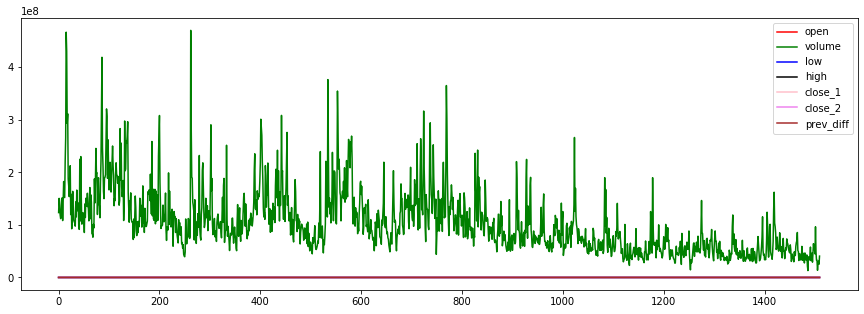

In [66]:
#Plots to check how they are changing with time

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.volume.values, color='green', label='volume')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.plot(X_train.close_1.values, color='pink', label='close_1')
plt.plot(X_train.close_2.values, color='violet', label='close_2')
plt.plot(X_train.prev_diff.values, color='brown', label='prev_diff')
plt.legend(loc='best')
plt.show()

In [67]:
#As the volume column doesn't seem to provide much insights and behaviours, we will drop it
X_train = X_train.drop("volume" , axis =1)
X_test = X_test.drop("volume" , axis =1)

#setting the date to float format to use it as a feature
X_train['date'] = X_train['date'].dt.strftime('%Y%m%d').astype(float)
X_test['date'] = X_test['date'].dt.strftime('%Y%m%d').astype(float)

In [68]:
#Normalizing the data 
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    min_max_scaler = MinMaxScaler()
    data["open"] = min_max_scaler.fit_transform(data.open.values.reshape(-1,1))
    data["low"] = min_max_scaler.fit_transform(data.low.values.reshape(-1,1))
    data["high"] = min_max_scaler.fit_transform(data.high.values.reshape(-1,1))
    data["date"] = min_max_scaler.fit_transform(data.date.values.reshape(-1,1))
    data["close_1"] = min_max_scaler.fit_transform(data.close_1.values.reshape(-1,1))
    data["close_2"] = min_max_scaler.fit_transform(data.close_2.values.reshape(-1,1))
    data["prev_diff"] = min_max_scaler.fit_transform(data.prev_diff.values.reshape(-1,1))
    
    return data

In [69]:
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

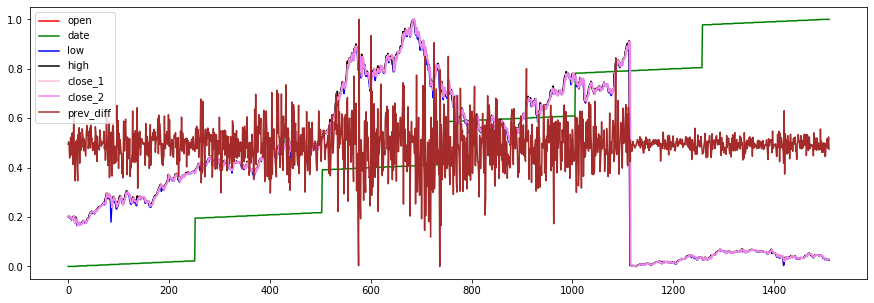

In [70]:
#Plotting again, this time along with date feature
plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.date.values, color='green', label='date')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.plot(X_train.close_1.values, color='pink', label='close_1')
plt.plot(X_train.close_2.values, color='violet', label='close_2')
plt.plot(X_train.prev_diff.values, color='brown', label='prev_diff')
plt.legend(loc='best')
plt.show()

Features seems to work well. 

In [71]:
#resulting shape
print(X_train.shape , Y_train.shape)
print("="*50)
print(X_test.shape, Y_test.shape)

(1510, 7) (1510,)
(252, 7) (252,)


# Model

In [18]:
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [29]:
#All the XGBregressor parameters that needs to be tuned.
#After checking, we have only kept the parameters which are having a significant impact on the results

parameters = {'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
              #'colsample_bylevel':[0.2, 0.4, 0.6, 0.8, 1.0],
              #'colsample_bynode':[0.2, 0.4, 0.6, 0.8, 1.0],
              'n_estimators' : [5, 10, 100, 500],
              'max_depth' : [*range(3,8,2)],
              'subsample' : [0.6, 0.8, 1.0],
              'learning_rate' : [0.01, 0.1 , 0.3]
             }

In [30]:
#Hyperparameter tuning using GridSearchCV on XGBregressor

XGB= XGBRegressor(objective='reg:squarederror', booster='gbtree', n_jobs=-1, gamma=0)
clf = GridSearchCV(XGB, parameters, scoring='neg_mean_squared_error',cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:squarederror',
                                    random_s...lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                    

In [31]:
#Getting the best set of parameters and the best MSE value achieved on the validation data 
print(clf.best_estimator_)
print('*'*100)
print(clf.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)
****************************************************************************************************
-248.46233641422043


In [32]:
#Using the best set of parameters to train the model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

XGB.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Predicting the value 

In [33]:
y_pred=XGB.predict(X_test)
y_actual = np.array(Y_test)

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_pred))

In [35]:
rms

337.6251085982121

Plotting the Actual vs Predicted closing prices.

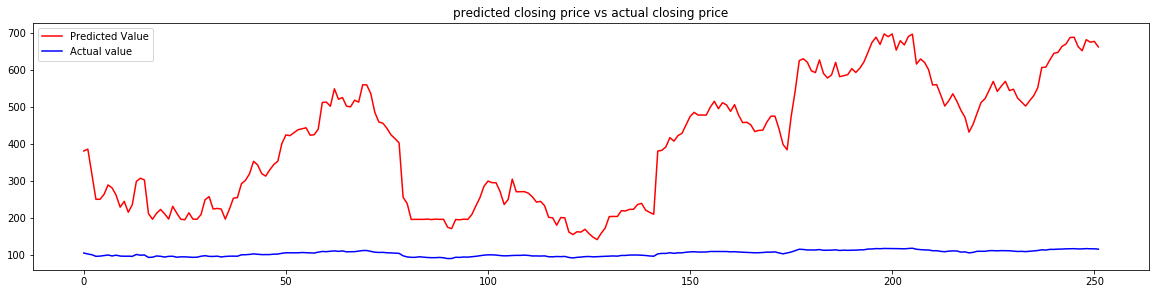

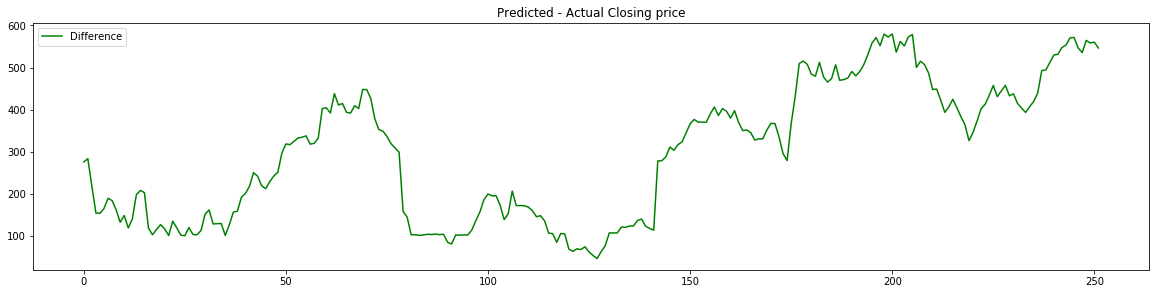

In [39]:
#Plotting the difference between the predicted and the actual value
from pylab import *

figure(figsize=(20,10))
subplot(2,1,1)
title('predicted closing price vs actual closing price')
plot(y_pred , color = 'r' , label = 'Predicted Value')
plot(y_actual , color = 'b' , label = 'Actual value')
legend()

figure(figsize=(20,10))
subplot(2,1,2)
title('Predicted - Actual Closing price')
plot(y_pred-y_actual , color = 'g' , label = 'Difference')

legend()
show()

__Conclusion__

XGBoost have performed poorly on the Apple data. 